> 导入库

In [4]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import itertools
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

> 导入数据，切分数据

In [5]:
# 读取数据
df_all = pd.read_csv('/Users/wangjingran/Desktop/PTEN mutation/L on ML/paras.txt', sep='\t')
# 数据切分
df_ASD_Cancer = df_all[df_all['Disease'].isin(['ASD', 'Cancer'])]
df_ASD_AC = df_all[df_all['Disease'].isin(['ASD', 'ASD_Cancer'])]
df_Cancer_AC = df_all[df_all['Disease'].isin(['Cancer', 'ASD_Cancer'])]

X = df_ASD_AC[['Entropy', 'Closeness', 'Degree']]
y = df_ASD_AC['Disease']

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
shuffle_index = np.random.permutation(X.index)
X = X.iloc[shuffle_index]
y = y.iloc[shuffle_index]


 # 切分数据集
X_train = X[:round(X.shape[0] * 0.7)]
X_test = X[round(X.shape[0] * 0.7):]
y_train = y[:round(X.shape[0] * 0.7)]
y_test = y[round(X.shape[0] * 0.7):]

> 模型训练

In [101]:
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=5)
rf_clf.fit(X_train, y_train)
gd_clf = GradientBoostingClassifier(n_estimators=1000, max_depth=5)
gd_clf.fit(X_train, y_train)
ad_clf = AdaBoostClassifier(n_estimators=1000)
ad_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=1000)

> 定义函数
所有计算出来的FPR放在一起去重、从小到大排序，然后对每一个FPR分别在对应的TPR相加求平均

In [19]:
def average(n):
    summ = 0
    for i in n:
        summ += i
    return summ/len(n)

def haverage_fpr(n):
    list1 = []
    for i in n:
        list1.append(i[0])
    set1 = set(list1)
    list1 = list(set1)
    list1 = sorted(list1)
    return list1
    

def haverage_tpr(n):
    list2 = []
    for i in haverage_fpr(n):
        list1 = []
        for j in n:
            if j[0] == i:
                list1.append(j[1])
        m = average(list1)
        list2.append(m)
    return list2

In [22]:
def multi_models_roc(names, sampling_methods, colors, X, y, save=True, dpin=100):
        """
        将多个机器模型的roc图输出到一张图上
        
        Args:
            names: list, 多个模型的名称
            sampling_methods: list, 多个模型的实例化对象
            save: 选择是否将结果保存(默认为png格式)
            
        Returns:
            返回图片对象plt
        """
        label_encoder = LabelEncoder()
        plt.figure(figsize=(20, 20), dpi=dpin)
        for (name, method, colorname) in zip(names, sampling_methods, colors):
            list_all = []
            for i in range(10):
                method_a = method
                X1 = X.reset_index(drop=True)
                y1 = y.reset_index(drop=True)
                shuffle_index = np.random.permutation(X.index)
                X1 = X1.iloc[shuffle_index]
                y1 = y1.iloc[shuffle_index]
                X_train = X1[:round(X.shape[0] * 0.7)]
                X_test = X1[round(X.shape[0] * 0.7):]
                y_train = y1[:round(X.shape[0] * 0.7)]
                y_test = y1[round(X.shape[0] * 0.7):]
                
                method_a.fit(X_train, y_train)

                y_pred_prob = method.predict_proba(X_test)[:,1]
                y_test_bi = label_encoder.fit_transform(y_test)
                fpr, tpr, thresholds = roc_curve(y_test_bi, y_pred_prob, pos_label=1)
                for i in range(len(fpr)):
                    list_all.append((fpr[i],tpr[i]))

            print(haverage_fpr(list_all))
            print(haverage_tpr(list_all))
            plt.plot(fpr, tpr, lw=3, label='{} (AUC={:.3f})'.format(name, auc(haverage_fpr(list_all), haverage_tpr(list_all))),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=3, color = 'grey')
            plt.axis('square')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('Specificity',fontsize=20)
            plt.ylabel('Sensitivity',fontsize=20)
            plt.title('ASD VS ASD_Cancer',fontsize=25)
            plt.legend(loc='lower right',fontsize=15)

        if save:
            plt.savefig('multi_models_roc.png')
            
        return plt


In [102]:
def multi_models_roc(names, sampling_methods, colors, X_test, y_test, save=True, dpin=100):
        """
        将多个机器模型的roc图输出到一张图上
        
        Args:
            names: list, 多个模型的名称
            sampling_methods: list, 多个模型的实例化对象
            save: 选择是否将结果保存(默认为png格式)
            
        Returns:
            返回图片对象plt
        """
        plt.figure(figsize=(20, 20), dpi=dpin)

        for (name, method, colorname) in zip(names, sampling_methods, colors):
            label_encoder = LabelEncoder()
            y_pred = method.predict(X_test)
            y_pred_prob = method.predict_proba(X_test)[:,1]
            y_test_bi = label_encoder.fit_transform(y_test)
            y_pred_bi = label_encoder.fit_transform(y_pred)
            fpr, tpr, thresholds = roc_curve(y_test_bi, y_pred_prob, pos_label=1)


            plt.plot(fpr, tpr, lw=3, label='{} (AUC={:.3f})'.format(name, auc(fpr, tpr)),color = colorname)
            plt.plot([0, 1], [0, 1], '--', lw=3, color = 'grey')
            plt.axis('square')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xlabel('Specificity',fontsize=20)
            plt.ylabel('Sensitivity',fontsize=20)
            plt.title('ASD VS ASD_Cancer',fontsize=25)
            plt.legend(loc='lower right',fontsize=15)

        if save:
            plt.savefig('multi_models_roc.png')
            
        return plt



> 绘制

[0.0, 0.023255813953488372, 0.02564102564102564, 0.02631578947368421, 0.027777777777777776, 0.046511627906976744, 0.05, 0.05128205128205128, 0.05263157894736842, 0.06976744186046512, 0.08333333333333333, 0.09302325581395349, 0.10256410256410256, 0.10526315789473684, 0.13157894736842105, 0.13953488372093023, 0.15, 0.15384615384615385, 0.15789473684210525, 0.18604651162790697, 0.20512820512820512, 0.20930232558139536, 0.21052631578947367, 0.2222222222222222, 0.23076923076923078, 0.23255813953488372, 0.23684210526315788, 0.25, 0.275, 0.27906976744186046, 0.28205128205128205, 0.2894736842105263, 0.3023255813953488, 0.3055555555555556, 0.3076923076923077, 0.325, 0.32558139534883723, 0.3333333333333333, 0.34210526315789475, 0.358974358974359, 0.37209302325581395, 0.375, 0.38461538461538464, 0.39473684210526316, 0.3953488372093023, 0.4166666666666667, 0.4358974358974359, 0.4418604651162791, 0.4473684210526316, 0.45, 0.46153846153846156, 0.46511627906976744, 0.4722222222222222, 0.4736842105263

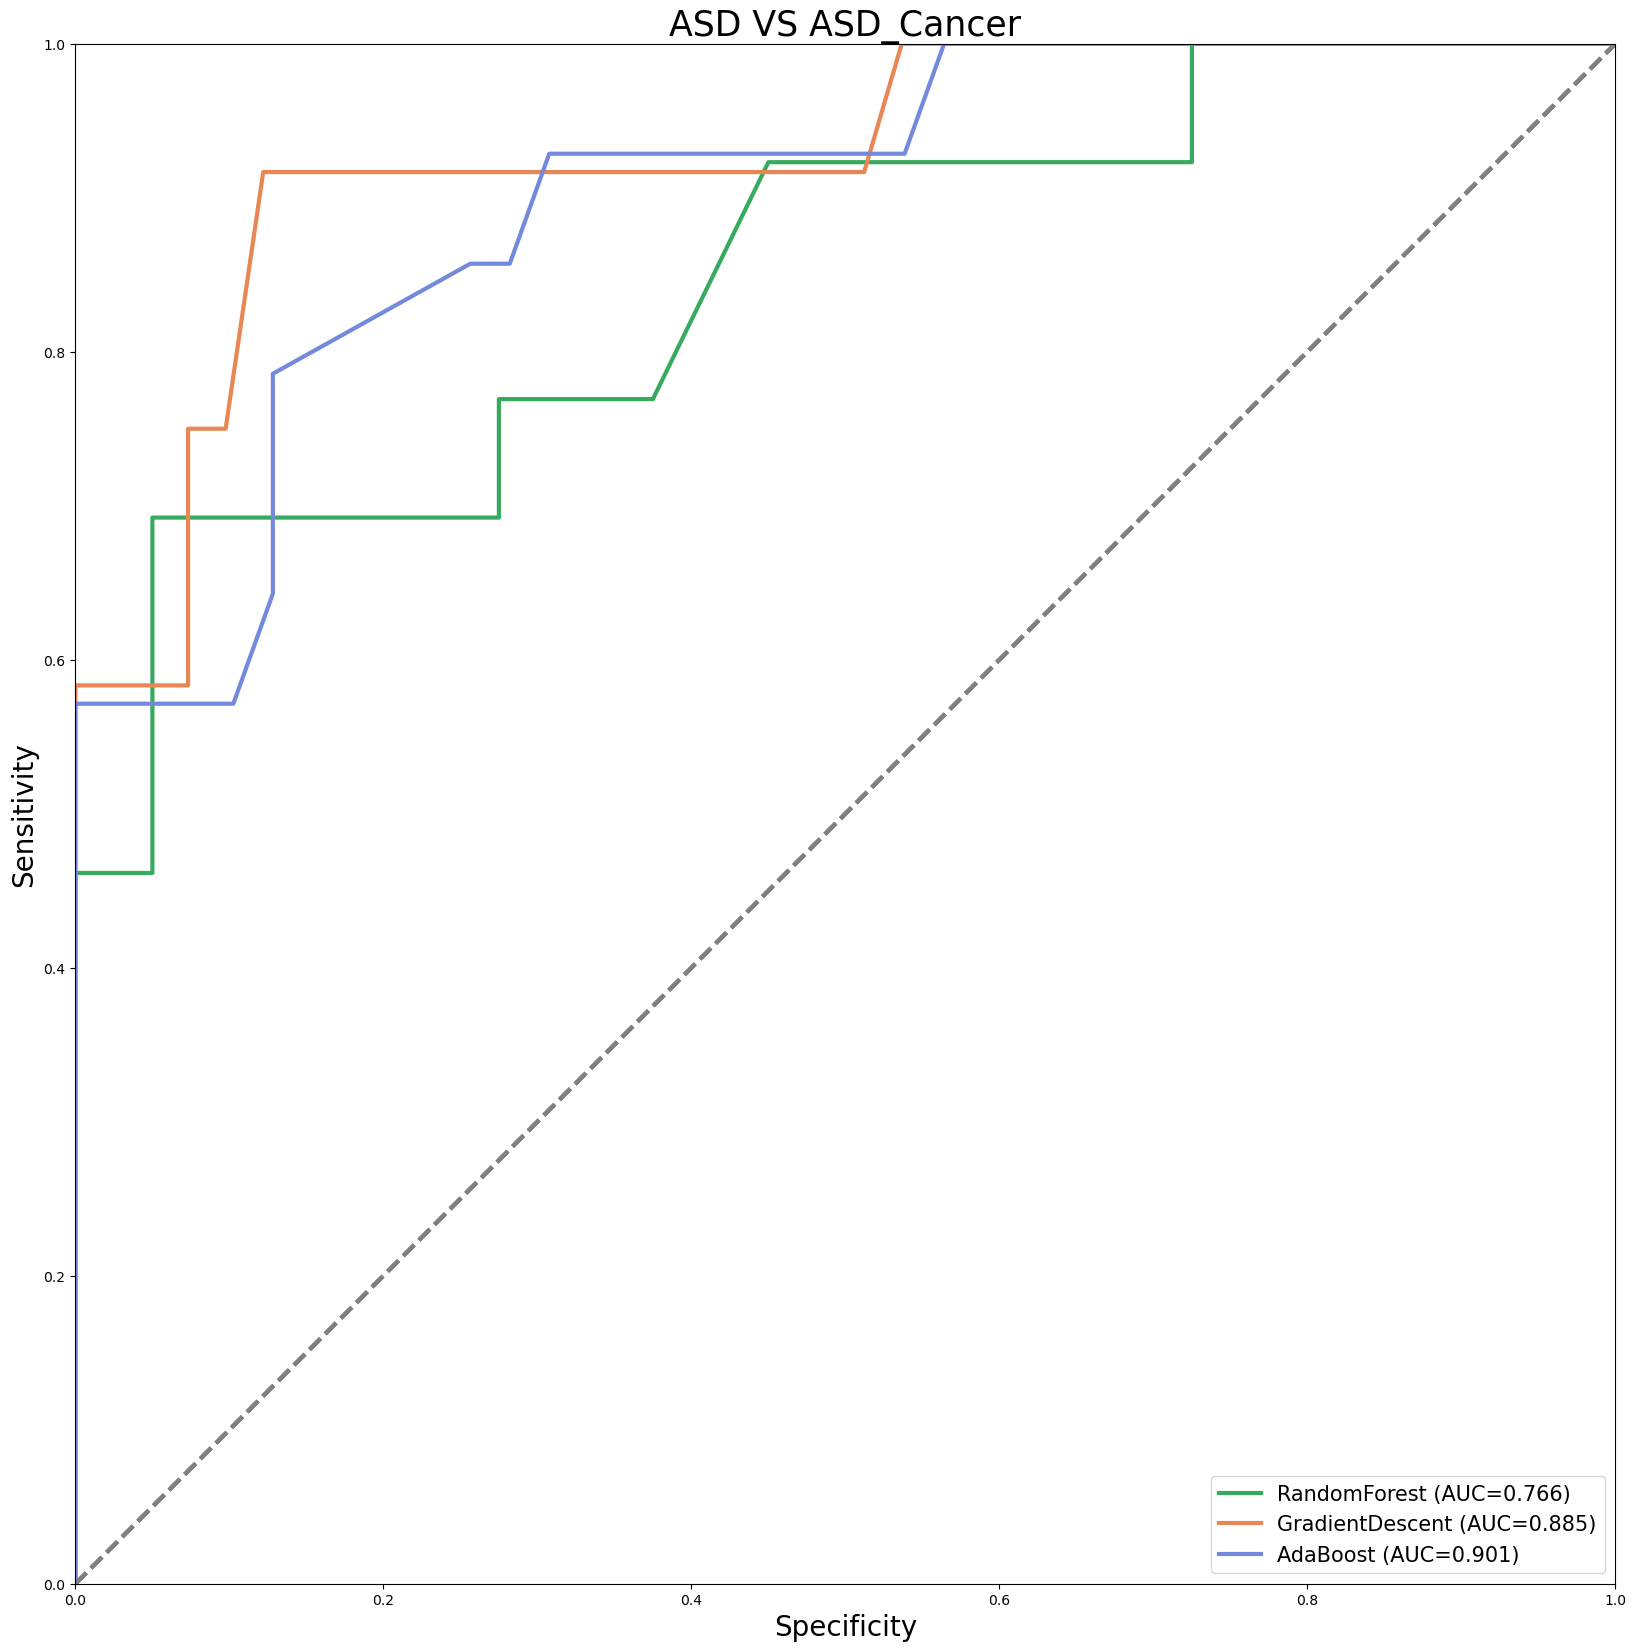

In [24]:
X = df_ASD_AC[['Entropy', 'Closeness', 'Degree']]
y = df_ASD_AC['Disease']
names = ['RandomForest', # 这个就是模型标签
         'GradientDescent',
         'AdaBoost']

sampling_methods = [RandomForestClassifier(n_estimators=1000, max_depth=5), # 这个就是训练的模型。
                    GradientBoostingClassifier(n_estimators=1000, max_depth=5),
                    AdaBoostClassifier(n_estimators=1000)
                   ]

colors = ['#36ab5d',  # 这个是曲线的颜色，几个模型就需要几个颜色哦！
          '#e88654',
          '#7389dd'
         ]

#ROC curves
test_roc_graph = multi_models_roc(names, sampling_methods, colors, X, y, save = False)  # 这里可以改成训练集
test_roc_graph.savefig('figure/ROC_Train_all_1.pdf')